In [17]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# importing k means clustering
from sklearn.cluster import KMeans

class GMM():
    def __init__(self, k, max_iter=10):
        self.k = k
        self.ll = []
        self.X = None
        self.max_iter = int(max_iter)
        self.centroids = None
        self.covariances = None
        self.pi_weights = None
    
    # copilot
    def calc_Gaussian(self, X, mean, cov):
        # calculating gaussian probability
        n = X.shape[1]
        diff = X - mean
        if np.linalg.det(cov) < n:  # If matrix is singular
            cov += np.eye(len(cov)) * 1e-6  # Add a small regularization term
        numerator = np.exp(-0.5 * np.sum(np.dot(diff, np.linalg.inv(cov)) * diff, axis=1))
        denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))
        return numerator / denominator
    
    
    def initial_setup(self, X):
        # performing k-means++ clustering to get initial centroids
        kmeans = KMeans(n_clusters=self.k, init='k-means++', max_iter=self.max_iter, n_init=1)
        kmeans.fit(X)
        self.centroids = kmeans.cluster_centers_

        # calculating covariance matrix for each cluster
        self.labels = kmeans.labels_
        init_covariances = []
        for i in range(self.k):
            init_covariances.append(np.cov(X[self.labels == i].T)) # copilot
        self.covariances = np.array(init_covariances)

        # calculating pi weights
        temp = []
        for i in range(self.k):
            temp.append(np.random.uniform(0, 1))
        s_t = sum(temp)
        self.pi_weights = np.array([i/s_t for i in temp])

    
    def e_m (self):
        # expectation step
        self.gamma = np.zeros((self.k, len(self.X)))
        for i in range(self.k):
            self.gamma[i] = self.pi_weights[i] * self.calc_Gaussian(self.X, self.centroids[i], self.covariances[i])        
        
        self.gamma = self.gamma / self.gamma.sum(0) 
        
        # maximization step
        for i in range(self.k):
            N_k = self.gamma[i].sum()
            self.centroids[i] = np.dot(self.gamma[i], self.X) / N_k
            self.covariances[i] = np.dot(self.gamma[i] * (self.X - self.centroids[i]).T, (self.X - self.centroids[i])) / N_k
            self.pi_weights[i] = N_k / len(self.X)

        # calculating log likelihood
        self.ll.append(self.log_likelihood())
    
    
    def return_params(self):
        # returning parameters
        return self.centroids, self.covariances, self.pi_weights 

    def log_likelihood(self):
        # calculating log likelihood
        ll = np.zeros((self.k, len(self.X)))
        for i in range(self.k):
            ll[i] = (self.calc_Gaussian(self.X, self.centroids[i], self.covariances[i]) * self.pi_weights[i])
        # taking ln
        ll =  np.log(ll.sum(0))
        # summing up
        ll = ll.sum()
        return ll
    
    def return_ll(self):
        # returning log likelihood
        return self.ll
    
    def return_gamma(self):
        # returning gamma
        return self.gamma
    
    def aic(self):
        # calculating aic
        return -2 * self.return_ll()[-1] + 2*self.k* (2* self.X.shape[1] + 1)
    
    def bic(self):
        # calculating bic
        return -2 * self.return_ll()[-1] + np.log(self.X.shape[0])*self.k*(2* self.X.shape[1] + 1)


    def fit(self, X):
        self.X = X
        self.initial_setup(X)
        for i in range(self.max_iter):
            self.e_m()
        return self
    
    def predict(self, X):
        # predicting cluster
        gamma = np.zeros((self.k, len(X)))
        for i in range(self.k):
            gamma[i] = self.pi_weights[i] * self.calc_Gaussian(X, self.centroids[i], self.covariances[i])
        gamma = gamma / gamma.sum(0)
        return np.argmax(gamma, axis=0)

    


Final Centroids:  [[1.         0.69979783 0.25917696 0.37427433 0.23477904 0.20716569
  0.01096244]
 [0.         0.         0.36354561 0.26336952 0.34157181 0.46381182
  0.48854041]
 [0.55541427 1.         0.28110558 0.43549815 0.34602115 0.5244459
  0.56654407]]

Final Covariances:  [[[ 1.00000000e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.10081826e-01 -1.09408357e-02  1.90366932e-02
    2.25464337e-03  6.53613215e-03 -7.67149082e-03]
  [ 0.00000000e+00 -1.09408357e-02  3.23283204e-02  2.21977154e-02
    3.03368739e-03 -5.19001036e-03  1.39292359e-04]
  [ 0.00000000e+00  1.90366932e-02  2.21977154e-02  2.87964760e-02
    3.76368502e-03 -2.53463722e-03 -1.67725039e-04]
  [ 0.00000000e+00  2.25464337e-03  3.03368739e-03  3.76368502e-03
    7.41147884e-03  1.28402983e-02  9.59228180e-04]
  [ 0.00000000e+00  6.53613215e-03 -5.19001036e-03 -2.53463722e-03
    1.28402983e-02  6.42673359e-02  4.05344265e-03]


Text(0, 0.5, 'Log Likelihood')

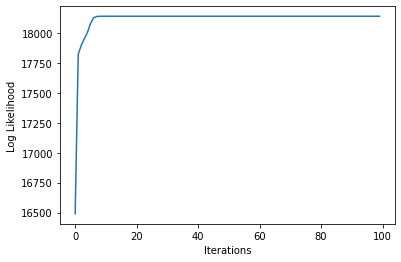

In [19]:
# Importing the dataset for Part 1
dataset = pd.read_csv('./SMAI-Dataset-customer-dataset/data.csv')

# dropping the index column
dataset = dataset.drop(['Index'], axis=1)

# normailsing the data
for col in dataset.columns:
    dataset[col] = (dataset[col] - dataset[col].min()) / (dataset[col].max() - dataset[col].min())

model = GMM(k=3, max_iter=100)
model.fit(dataset) # routine to fit
ll = model.return_ll() # routine to get log likelihood
centroids, covariances, pi_weights = model.return_params() # routine to get final parameters
memberships = model.return_gamma() # routine to get final memberships

print("\nFinal Centroids: ", centroids)
print("\nFinal Covariances: ", covariances)
print("\nFinal Pi Weights: ", pi_weights)
print("\nFinal Log Likelihood: ", ll[-1])
print("\nFinal Memberships: ", memberships)

plt.plot(ll)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')






Final Log Likelihood:  1661.3709258057206

Final Centroids:  [[0.55294167 0.48701948 0.56915219 0.54295599 0.32139787 0.25152126
  0.09915596 0.61265253 0.22211954 0.5051374  0.18396234 0.15248173
  0.25085995]
 [0.70222444 0.24786372 0.5832126  0.34547498 0.40763043 0.63924837
  0.55347139 0.29969479 0.47660644 0.35363334 0.47878622 0.69026014
  0.59016968]
 [0.31766233 0.24540212 0.47144996 0.49956825 0.24480249 0.43540049
  0.37079289 0.43099945 0.39151816 0.14976503 0.46201267 0.56818207
  0.15745911]]

Final Covariances:  [[[ 1.92361393e-02  5.35780770e-03  3.98071238e-03  4.65451798e-03
   -1.25039200e-03  2.81868887e-03  1.18577958e-04 -4.60247343e-04
    7.39195772e-03  1.03069624e-02 -2.63218129e-03  1.89843819e-03
   -6.70325575e-04]
  [ 5.35780770e-03  5.31391583e-02  2.99396853e-03  7.93641079e-03
   -5.32624682e-03 -8.38021578e-03 -5.89288322e-03  1.00804151e-03
   -5.64210768e-04  7.01410697e-04 -6.42469961e-03 -3.64534161e-04
   -7.87631470e-05]
  [ 3.98071238e-03  2.99

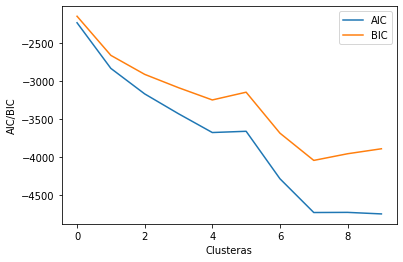

In [20]:
# Part 2
from sklearn.datasets import load_wine
data_wineset = load_wine()
dataset_w = pd.DataFrame(data_wineset.data, columns=data_wineset.feature_names)

# # normailsing the data
for col in dataset_w.columns:
    dataset_w[col] = (dataset_w[col] - dataset_w[col].min()) / (dataset_w[col].max() - dataset_w[col].min())

model = GMM(k=3, max_iter=100)
model.fit(dataset_w) # routine to fit
ll = model.return_ll() # routine to get log likelihood
print ("\nFinal Log Likelihood: ", ll[-1])
centroids, covariances, pi_weights = model.return_params() # routine to get final parameters
memberships = model.return_gamma() # routine to get final memberships

print("\nFinal Centroids: ", centroids)
print("\nFinal Covariances: ", covariances)
print("\nFinal Pi Weights: ", pi_weights)
print("\nGammas: ", memberships.T)

aic = []
bic = []
for i in range(1,11):
    model = GMM(k=i, max_iter=100)
    model.fit(dataset_w)
    aic.append(model.aic())
    bic.append(model.bic())


plt.plot(aic)
plt.plot(bic)
plt.xlabel('Clusteras')
plt.ylabel('AIC/BIC')
plt.legend(['AIC', 'BIC'])


### We find that the optimal number is at 2.

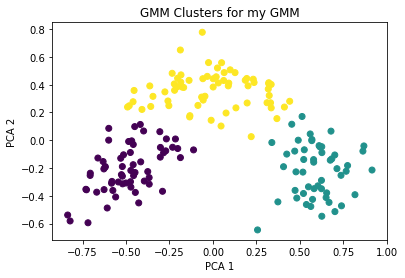

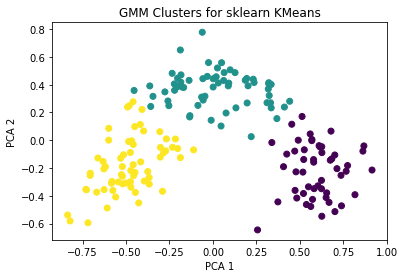

In [21]:
# reducing the dimensionality of the dataset to 2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dataset_w)
dataset_w = pca.transform(dataset_w)

# plotting the dataset for my GMM
gmm_custom = GMM(k=3, max_iter=100)
gmm_custom.fit(dataset_w)
gmm_custom_pred = gmm_custom.predict(dataset_w)

plt.scatter(dataset_w[:,0], dataset_w[:,1], c=gmm_custom_pred)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('GMM Clusters for my GMM')
plt.show()

# plotting the dataset for sklearn KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(dataset_w)
kmeans_pred = kmeans.predict(dataset_w)

plt.scatter(dataset_w[:,0], dataset_w[:,1], c=kmeans_pred)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('GMM Clusters for sklearn KMeans')
plt.show()



In [22]:
# Silhouette Score
from sklearn.metrics import silhouette_score
print("Silhouette Score for my GMM: ", silhouette_score(dataset_w, gmm_custom_pred))
print("Silhouette Score for sklearn KMeans: ", silhouette_score(dataset_w, kmeans_pred))



Silhouette Score for my GMM:  0.5662252913596104
Silhouette Score for sklearn KMeans:  0.5680591392935428
